In [ ]:
# Код из вебинара не работает
# Вот ошибка:
# 28         output = model(X, lengths)
#      29         loss = criterion(output, y)
#      30         loss_accumed += loss

        
        
# ~/Documents/gb/env/lib/python3.9/site-packages/torch/nn/modules/module.py in _call_impl(self, *input, **kwargs)
#    1108         if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks or _global_backward_hooks
#    1109                 or _global_forward_hooks or _global_forward_pre_hooks):
# -> 1110             return forward_call(*input, **kwargs)
#    1111         # Do not call functions when jit is used
#    1112         full_backward_hooks, non_full_backward_hooks = [], []

# TypeError: forward() takes 2 positional arguments but 3 were given
    
# Полагаю из-за передачи параметра lenght в model() вместе с Х
# Я его убрала, и чудо-код начал выдавать тренировочную и тестовую ошибку равную 0
# в этом датасете то-же самое
# изменила функцию ошибки и активацию на выходе, ошибка появилась, но она не изменяется от 
# эпохе к эпохе (или растет на тесте).
# пыталась еще добавить сверток и maxpool слоев - 2 сети с отличиями в методе forward
# результат работает точно так-же, только ошибка выше.
# чуть лучше вариант с MSELoss но эта ошибка не подходит к задаче
# В общем, сплошное расстройство. В теме, увы, не разобралась.

In [47]:
import torch
import torchvision
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from collections import Counter
import re
import random
from functools  import lru_cache
from FeedBack_5 import FeedBackData

In [2]:
#pip install xlrd

In [3]:
data = pd.read_excel("отзывы за лето.xls", engine='xlrd')

In [4]:
data.Content.values

array(['It just works!',
       'В целом удобноное приложение...из минусов хотят слишком большой доступ к персональным данным в телефоне,приходится пользоваться в ограниченном режиме',
       'Отлично все', ..., 'Доволен', 'Песопаснасть, рут ни нужын',
       'Сбербанк бомбовая компания на сегодняшний день. Лидер банков.!! Держитесь в том же духе.'],
      dtype=object)

In [5]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [6]:
len(data)

20659

In [7]:
data = data.dropna()

In [8]:
data = data.loc[data["Rating"] != 3]
data['Rating'] = np.where(data['Rating'] >= 4, 1, 0 )

In [9]:
data.tail()

,Rating,Content,Date
20654,0,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,1,Ок,2017-06-01
20656,1,Доволен,2017-06-01
20657,0,"Песопаснасть, рут ни нужын",2017-06-01
20658,1,Сбербанк бомбовая компания на сегодняшний день...,2017-06-01


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19745 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   19745 non-null  int64 
 1   Content  19745 non-null  object
 2   Date     19745 non-null  object
dtypes: int64(1), object(2)
memory usage: 617.0+ KB


In [11]:
sw = get_stop_words('ru')
ex = set(punctuation)
morpher = MorphAnalyzer()

In [12]:
def feedback_preprocessing(text_data):
    text_data = str(text_data).lower()
    text_data = ''.join(i for i in text_data if i not in ex)
    text_data = re.sub('не\s*', 'не', text_data)
    text_data = ' '.join([morpher.parse(word)[0].normal_form for word in text_data.split() if word not in sw])
    return text_data
    

In [13]:
data['Content'] = data['Content'].apply(feedback_preprocessing)

In [14]:
data.Content.values

array(['it just works',
       'целое удобноной приложениеиз минус хотеть большой доступ персональный данные телефонеприходиться пользоваться ограниченный режим',
       'отлично', ..., 'довольный', 'песопаснастя рута нужын',
       'сбербанк бомбовый компания сегодняшний лидер банк держаться дух'],
      dtype=object)

In [15]:
data_words = data.Content.values
counter = Counter()
for sentense in data_words:
    counter.update(sentense.split())


In [16]:
print(f'Number of words before: {len(counter.keys())}')

Number of words before: 11637


In [17]:
for word, count in list(counter.items()):
    if count < 10:
        del counter[word]

In [18]:
print(f'Number of words after: {len(counter.keys())}')

Number of words after: 1100


In [19]:
vocabindex = {"":0, "UNK":1}
words = ["", "UNK"]

for word in counter:
    vocabindex[word] = len(words)
    words.append(word)

In [20]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [21]:
# class FeedBackData(torch.utils.data.Dataset):
    
#     def __init__(self, txt, labels, vocabulary, user_len):
#         self.txt = txt
#         self.labels = labels
#         self.vocabulary = vocabulary
#         self.user_len = user_len
    
#     def __len__(self):
#         return len(self.txt)
        
        
#     @lru_cache(50000)
#     def encode_sentence(self, txt):
#         encoded = np.zeros(self.user_len, dtype=int)
#         num_encoder = np.array([self.vocabulary.get(word, self.vocabulary["UNK"]) for word in self.txt])
#         final_len = min(user_len, len(num_encoder))
#         encoded[:final_len] = num_encoder[:final_len]
#         return encoded, final_len
        
#     def __getitem__(self, ind):
#         encoded, final_len = self.encode_sentence(self.txt[ind])
#         return torch.from_numpy(encoded.astype(np.int32)), float(self.labels[ind]), final_len

In [22]:
X, y = data['Content'].values, data['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
len(X_train), len(y_train)

(14808, 14808)

In [23]:
y_train

array([1, 1, 1, ..., 1, 0, 0])

In [24]:
data['Date'] = pd.to_datetime(data['Date'])

In [25]:
data['Date'].max() - data['Date'].min()

Timedelta('74 days 00:00:00')

In [26]:
content_len = []
for i in data['Content']:    
    i_len = len(i)
    content_len.append(i_len)
    
data['Content_len'] = content_len    

In [27]:
data['Content_len'].mean(), data['Content_len'].median(), data['Content_len'].quantile(q=0.75) 

(39.135224107368956, 19.0, 45.0)

<AxesSubplot:>

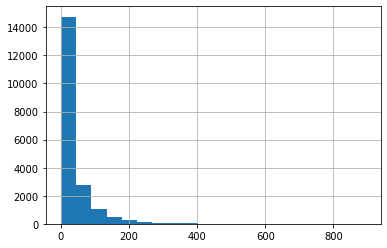

In [28]:
data['Content_len'].hist(bins=20)

In [29]:
user_len = round(data['Content_len'].quantile(q=0.75))
print(user_len)

45


In [30]:
final_train = FeedBackData(X_train, y_train, vocabindex, user_len +1)
final_test = FeedBackData(X_test, y_test, vocabindex, user_len +1)

In [31]:
train_loader = torch.utils.data.DataLoader(final_train,
                                          batch_size=200,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)
test_loader = torch.utils.data.DataLoader(final_test,
                                         batch_size=200,
                                         shuffle=False,
                                         num_workers=1,
                                         drop_last=True)

In [240]:
class MyNet(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim=128, out_channel=128, num_classes=1):
        super(MyNet, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.lin = nn.Linear(out_channel, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.soft = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = torch.max(x, axis=2).values
        x = self.lin(x)
        x = self.sigmoid(x)
        #x = self.soft(x)
        return x
    
    def predict(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = torch.max(x, axis=2).values
        x = self.lin(x)
        #x = self.soft(x)
        x = self.sigmoid(x)
        return x
        

In [241]:
net = MyNet(len(vocabindex))
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
criterion = nn.BCELoss()

In [53]:
def train_test(train_loader, test_loader, net, optimizer, criterion, num_epochs):
    
    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0
        loader_len = len(train_loader)
        for ind, data in enumerate(train_loader, 0):
            text, label, lenght = data[0], data[1], data[2]
            text = text.long()
            label = label.view(-1, 1)
            optimizer.zero_grad()
            
            prediction = net(text)
            loss = criterion(prediction.float(), label.float())
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
          
        
        net.eval()
        eval_loss = 0
        for X, y, test_lenght in test_loader:
            X = X.long()
            y = y.view(-1, 1)
            preds = net(X)
            test_loss = criterion(preds.float(), y.float())
            eval_loss += test_loss.item()
        print(f'Epoch {epoch + 1}, Train_loss {epoch_loss}')     
        print(f'Epoch {epoch + 1}, Test_loss {eval_loss}')     

In [243]:
train_test(train_loader, test_loader, net, optimizer, criterion, 4)

 20%|█████████                                    | 1/5 [00:27<01:48, 27.16s/it]

Epoch 1, Train_loss 21.372144177556038
Epoch 1, Test_loss 5.717549026012421


 40%|██████████████████                           | 2/5 [00:53<01:20, 26.84s/it]

Epoch 2, Train_loss 15.203357517719269
Epoch 2, Test_loss 5.0455277264118195


 60%|███████████████████████████                  | 3/5 [01:21<00:54, 27.15s/it]

Epoch 3, Train_loss 12.707930162549019
Epoch 3, Test_loss 4.742950394749641


 80%|████████████████████████████████████         | 4/5 [01:48<00:27, 27.18s/it]

Epoch 4, Train_loss 10.72528937458992
Epoch 4, Test_loss 4.6386109590530396


100%|█████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]

Epoch 5, Train_loss 9.272441945970058
Epoch 5, Test_loss 5.159739464521408


In [136]:
class ImprovedNet(nn.Module):
    
    

    def __init__(self, vocab_size, embedding_dim, output_channels,
                 num_classes, kernel_sizes, stride=1, binary=False):
        super(ImprovedNet, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_channels = output_channels
        self.num_classes = num_classes
        self.relu = nn.ReLU()
        if binary:
            self.finish = nn.Sigmoid()
        else:
            self.finish = nn.Softmax(dim=1)
            
        # kernel_sizes    
        self.kernel1 = kernel_sizes[0]
        self.kernel2 = kernel_sizes[1]
        self.kernel3 = kernel_sizes[2]
        self.stride = stride
            
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                     embedding_dim=self.embedding_dim)    
        
        # convolutional_layers
        self.conv1 = nn.Conv1d(in_channels=self.embedding_dim,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel1)
        self.conv2 = nn.Conv1d(in_channels=self.output_channels,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel2)
        self.conv3 = nn.Conv1d(in_channels=self.output_channels,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel3)
                              
        
        # maxpooling layers
        self.maxpool1 = nn.MaxPool1d(kernel_size=self.kernel1, stride=self.stride)
        self.maxpool2 = nn.MaxPool1d(kernel_size=self.kernel2, stride=self.stride)
        self.maxpool3 = nn.MaxPool1d(kernel_size=self.kernel3, stride=self.stride)
    
        self.lin = nn.Linear(in_features=self.output_channels, out_features=num_classes)      
    
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)      
        x1 = self.relu(self.conv1(x))
        x1 = self.maxpool1(x1)
        x2 = self.relu(self.conv2(x))
        x2 = self.maxpool2(x2)
        x3 = self.relu(self.conv3(x))
        x3 = self.maxpool3(x3)
        final = torch.cat((x1, x2, x3), dim=2)
        final = torch.max(final, axis=2).values
        final = self.lin(final)
        return self.finish(final)
        
    def predict(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x1 = self.relu(self.conv1(x))
        x1 = self.maxpool1(x1)
        x2 = self.relu(self.conv2(x))
        x2 = self.maxpool2(x2)
        x3 = self.relu(self.conv3(x))
        x3 = self.maxpool3(x3)
        final = torch.cat((x1, x2, x3), dim=2)      
        final = torch.max(final, axis=2).values
        final = self.lin(final)
        return self.finish(final)
        

In [137]:
newnet = ImprovedNet(len(vocabindex), 200, 200, kernel_sizes=[3,4,5],num_classes=1, binary=True)
newoptimizer = torch.optim.Adam(newnet.parameters(), lr=0.01)
newcriterion = nn.BCELoss()

In [138]:
print(newnet)

ImprovedNet(
  (relu): ReLU()
  (finish): Sigmoid()
  (embedding): Embedding(1102, 200)
  (conv1): Conv1d(200, 200, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(200, 200, kernel_size=(4,), stride=(1,))
  (conv3): Conv1d(200, 200, kernel_size=(5,), stride=(1,))
  (maxpool1): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lin): Linear(in_features=200, out_features=1, bias=True)
)


In [139]:
train_test(train_loader, test_loader, newnet, newoptimizer, newcriterion, 5)

 20%|████████▊                                   | 1/5 [01:44<06:58, 104.66s/it]

Epoch 1, Train_loss 1126.8047289848328
Epoch 1, Test_loss 356.5


 40%|█████████████████▌                          | 2/5 [03:50<05:50, 116.98s/it]

Epoch 2, Train_loss 1142.0
Epoch 2, Test_loss 356.5


 60%|██████████████████████████▍                 | 3/5 [05:42<03:49, 114.69s/it]

Epoch 3, Train_loss 1143.5
Epoch 3, Test_loss 356.5


 80%|███████████████████████████████████▏        | 4/5 [07:51<02:00, 120.63s/it]

Epoch 4, Train_loss 1144.5
Epoch 4, Test_loss 356.5


100%|████████████████████████████████████████████| 5/5 [09:45<00:00, 117.07s/it]

Epoch 5, Train_loss 1144.0
Epoch 5, Test_loss 356.5


In [162]:
class ImprovedNet(nn.Module): 

    def __init__(self, vocab_size, embedding_dim, output_channels,
                 num_classes, kernel_sizes, stride=1, binary=False):
        super(ImprovedNet, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_channels = output_channels
        self.num_classes = num_classes
        self.relu = nn.ReLU()
        if binary:
            self.finish = nn.Sigmoid()
        else:
            self.finish = nn.Softmax(dim=1)
            
        # kernel_sizes    
        self.kernel1 = kernel_sizes[0]
        self.kernel2 = kernel_sizes[1]
        self.kernel3 = kernel_sizes[2]
        self.stride = stride
            
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size,
                                     embedding_dim=self.embedding_dim)    
        
        # convolutional_layers
        self.conv1 = nn.Conv1d(in_channels=self.embedding_dim,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel1)
        self.conv2 = nn.Conv1d(in_channels=self.output_channels,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel2)
        self.conv3 = nn.Conv1d(in_channels=self.output_channels,
                              out_channels=self.output_channels,
                              kernel_size=self.kernel3)
                              
        
        # maxpooling layers
        self.maxpool1 = nn.MaxPool1d(kernel_size=self.kernel1, stride=self.stride)
        self.maxpool2 = nn.MaxPool1d(kernel_size=self.kernel2, stride=self.stride)
        self.maxpool3 = nn.MaxPool1d(kernel_size=self.kernel3, stride=self.stride)
    
        self.lin = nn.Linear(in_features=self.output_channels, out_features=num_classes)      
    
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)      
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)
        final = torch.max(x, axis=2).values
        final = self.lin(final)
        return final
        
    def predict(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)    
        final = torch.max(x, axis=2).values
        final = self.lin(final)
        return final

In [163]:
newnet = ImprovedNet(len(vocabindex), 200, 200, kernel_sizes=[3,4,5],num_classes=1, binary=True)
newoptimizer = torch.optim.Adam(newnet.parameters(), lr=0.01)
newcriterion = nn.MSELoss()

In [164]:
train_test(train_loader, test_loader, newnet, newoptimizer, newcriterion, 5)

 20%|█████████                                    | 1/5 [01:31<06:07, 91.76s/it]

Epoch 1, Train_loss 58202.92558220774
Epoch 1, Test_loss 2.817018151283264


 40%|██████████████████                           | 2/5 [02:59<04:27, 89.10s/it]

Epoch 2, Train_loss 7.6933912336826324
Epoch 2, Test_loss 2.4028851240873337


 60%|███████████████████████████                  | 3/5 [04:27<02:57, 88.68s/it]

Epoch 3, Train_loss 6.871077559888363
Epoch 3, Test_loss 2.423503704369068


 80%|████████████████████████████████████         | 4/5 [05:59<01:29, 89.92s/it]

Epoch 4, Train_loss 6.360571701079607
Epoch 4, Test_loss 2.3421196788549423


100%|█████████████████████████████████████████████| 5/5 [07:24<00:00, 88.95s/it]

Epoch 5, Train_loss 5.517770428210497
Epoch 5, Test_loss 2.3561914190649986
